## Extracting connected components

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import time

In [2]:
#Decorator to calculate the time to finish the function
def calculate_time(func):
    def inner_function(*args, **kwargs):
        begin = time.time()
        img_ = func(*args,**kwargs)
        end = time.time()
        print("Total Time taken = ",end-begin)
        return img_
    return inner_function

The function for performing Dilation is declared below

In [3]:
def morphological_operate(img,ker,choice='dilate'):
    img_ = np.zeros(img.shape)
    kx,ky = ker.shape
    kx,ky = int(kx/2),int(ky/2)
    for i in range(kx,img.shape[0]-kx):
        for j in range(ky,img.shape[1]-ky):
            select = img[i-kx:i+kx+1,j-ky:j+ky+1]
            if choice=='erode':
                img_[i][j] = np.logical_not(np.sum(np.logical_not(select.copy()).any() and ker.any()))
            elif choice=='dilate':
                img_[i][j] = np.sum(select.any() and ker.any())
    return img_.astype(int)

Below is the function to Find the components. The way it works is explained in brief below<br>
This process is based on iteration of the expression below,
$$X_{k} = (X_{k-1} \oplus B) \bigcap A; \;   _{where \, k=1,2,3,...}$$ 
$$\;\;\;\;_{until} \;X_{k} = X_{k-1}$$
Here, B is the Structuring element, A is the original thresholded image and $X_{k-1}$ refers to the matrix formed by first non-zero element for k=1, for rest of the $k$s, the expression takes care.<br>It is to be noted that the input image should be binarized before hand.

In [13]:
@calculate_time
def find_labels(img,structural_element):
    m,n = img.shape[0],img.shape[1]
    N=1
    output = np.zeros(img.shape)
    for i in range(m):
        for j in range(n):
            if img[i][j]!=0:
                print("non-zero pixel found at ",i,",",j)
                X = np.zeros(img.shape)
                X[i][j] = 1
                Y = np.logical_and(morphological_operate(X,structural_element.copy()),img.copy())
                while np.array_equal(Y,X)!=True:
                    Y=Y.astype(int)
                    X = Y.copy()
                    Y = np.logical_and(morphological_operate(X,structural_element.copy()),img.copy())
                nz_ele = np.nonzero(Y)
                output[nz_ele] = N
                img[nz_ele]= 0
                N = N+1
                
                    
    return (output,N-1)

- Function <b>get_histogram()</b>: It takes in the image and returns the histogram of the function
- Function <b>ostu_threshold()</b>: Returns the suitable threshold value to binarize the image, takes in the histogram of the image as argument.
- Function <b>fill_holes()</b>: It fills the holes of thresholded image so that the structure of components are complete and also can be classified as connected
- Function <b>thresholder()</b>: It binarizes the image and returns the image which can be used to perform the Component Finding process. Here, the fill_holes() function is called.

#### Details of OTSU's Thresholding
In Otsu's method, we take a value of intensity and calculate the weighted in-class variance of it by the formula given below
$$\sigma _{w}^{2} = W_{b} \sigma_{b}^{2} +W_{f} \sigma_{f}^{2}$$
where, <br>$W_{b,f}$ are the Normalized number of pixels in Background or Foreground and<br>$\sigma_{b,f}$ are Variance of Background or Foreground

In [5]:
def get_histogram(img):
    max_val = np.amax(img)
    k=1
    while k<max_val:
        k=k*2
    histogram = np.zeros(k)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            histogram[img[i][j]] = histogram[img[i][j]]+1
    return histogram


def otsu_threshold(hist,graph=False):
    sig=[]
    for mid in range(2,len(hist)):
        background = hist[:mid-1]
        foreground = hist[mid:]
        N = sum(hist)
        Wb = np.cumsum(background)[-1]/N
        Wf = np.cumsum(foreground)[-1]/N
        ub,uf,Nb,Nf=0,0,sum(background),sum(foreground)
        sigmaB,sigmaF = 0,0
        ub = sum(np.arange(len(background))*background)/ (Wb*N+1)
        sigmaB = sum((np.arange(len(background))-ub)**2*background)/Nb
        uf = sum(np.arange(len(foreground))*foreground)/ (Wf*N+1)
        sigmaF = sum((np.arange(len(foreground))-uf)**2*foreground)/Nf
        sig.append(Wb*sigmaB + Wf*sigmaF)
    if graph:
        plt.plot(np.arange(len(sig)),sig)
        plt.title("Weighted inter-class variance")
        plt.show()
    sig = np.nan_to_num(sig)
    return np.nonzero(sig==np.amin(sig[sig!=0]))[0]

def fill_holes(img):
    img=img.astype(int)
    inverted_img = cv2.bitwise_not(img.copy())
    h,w = img.shape
    mask = np.zeros((h+2,w+2),np.uint8)
    cv2.floodFill(inverted_img,mask,(0,0),255)
    inverted_img = cv2.bitwise_not(inverted_img)
    img_out = cv2.bitwise_or(inverted_img,img)
    return img_out.astype(int)


def thresholder(img,t):
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if img[i][j] > t:
                img[i][j] = 0
            else:
                img[i][j] = 1
    #img = fill_holes(img) + 255
    print('Flood fill min - ',np.amin(img))
    print('Flood fill max - ',np.amax(img))
    return img

Total Time taken =  14.539887428283691


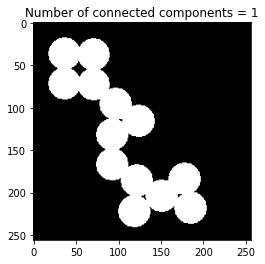

In [10]:
SE = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(20,20))
circles = cv2.imread('circles.png')
circles = cv2.cvtColor(circles,cv2.COLOR_BGR2GRAY)
out,N = find_labels(circles.copy(),SE)
plt.imshow(out,cmap='gray')
plt.title('Number of connected components = '+str(N))
plt.show()

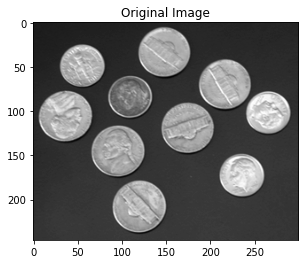

In [11]:
SE = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
img = cv2.imread('coins.png')
img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
plt.imshow(img,cmap='gray')
plt.title("Original Image")
plt.show()

/tmp/ipykernel_26825/209183533.py:24: RuntimeWarning: invalid value encountered in double_scalars
  sigmaB = sum((np.arange(len(background))-ub)**2*background)/Nb


Flood fill min -  0
Flood fill max -  255


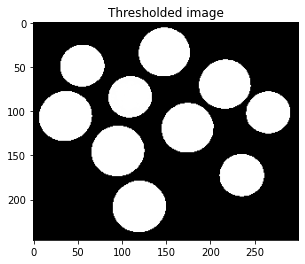

In [12]:
otsu_thres = otsu_threshold(get_histogram(img.copy()))
img_t = thresholder(img.copy(),otsu_thres)
plt.imshow(img_t,cmap='gray')
plt.title("Thresholded image")
plt.show()

Total Time taken =  180.1406650543213


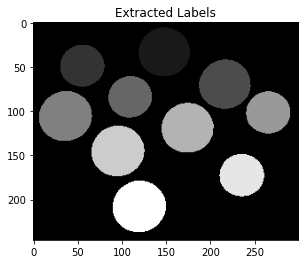

In [13]:
out,N = find_labels(img_t.copy(),SE)
plt.imshow(out,cmap='gray')
plt.title('Extracted Labels')
plt.show()

In [14]:
print('Number of components = ',N)

Number of components =  10


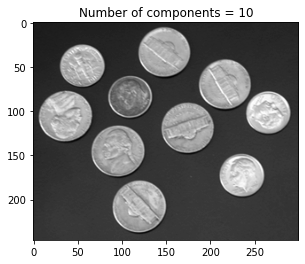

In [15]:
plt.imshow(img,cmap='gray')
plt.title("Number of components = "+str(N))
plt.show()

#### Lab Assignments

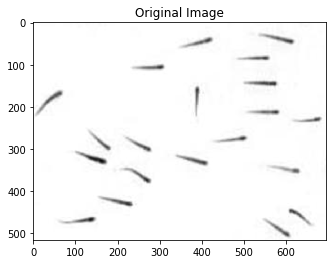

In [23]:
SE = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(10,10))
img = cv2.imread('fish.png')
img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
plt.imshow(img,cmap='gray')
plt.title("Original Image")
plt.show()

/tmp/ipykernel_26825/1303474914.py:24: RuntimeWarning: invalid value encountered in double_scalars
  sigmaB = sum((np.arange(len(background))-ub)**2*background)/Nb


Flood fill min -  0
Flood fill max -  255


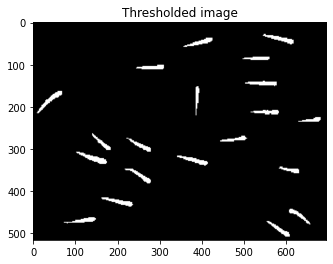

255


In [24]:
otsu_thres = otsu_threshold(get_histogram(img.copy()))
img_t = thresholder(img.copy(),otsu_thres)
plt.imshow(img_t,cmap='gray')
plt.title("Thresholded image")
plt.show()
print(np.amax(img_t))

Total Time taken =  812.9294176101685


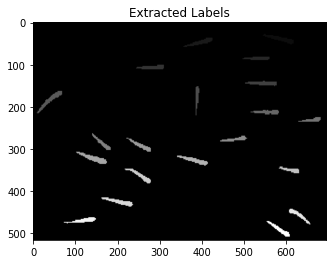

Number of components =  20


In [25]:
out,N = find_labels(img_t.copy(),SE)
plt.imshow(out,cmap='gray')
plt.title('Extracted Labels')
plt.show()
print('Number of components = ',N)

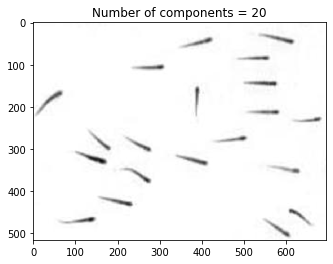

In [26]:
plt.imshow(img,cmap='gray')
plt.title("Number of components = "+str(N))
plt.show()

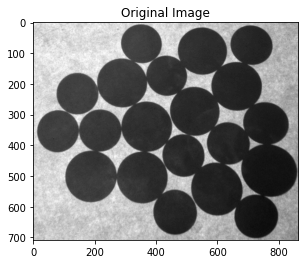

In [8]:
SE = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(20,20))
img = cv2.imread('coins1.png')
img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
plt.imshow(img,cmap='gray')
plt.title("Original Image")
plt.show()

/tmp/ipykernel_2334/1643984863.py:24: RuntimeWarning: invalid value encountered in double_scalars
  sigmaB = sum((np.arange(len(background))-ub)**2*background)/Nb


Flood fill min -  0
Flood fill max -  255


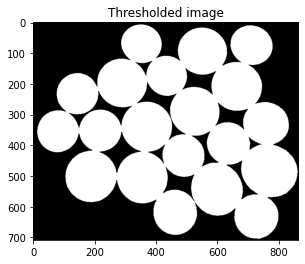

In [9]:
def thresholdInvert(img,t):
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if img[i][j] > t:
                img[i][j] = 255
            else:
                img[i][j] = 0
    #img = fill_holes(img) + 255
    print('Flood fill min - ',np.amin(img))
    print('Flood fill max - ',np.amax(img))
    return img
otsu_thres = otsu_threshold(get_histogram(img.copy()))
img_t = thresholdInvert(img.copy(),otsu_thres)
img_t = cv2.bitwise_not(img_t)
plt.imshow(img_t,cmap='gray')
plt.title("Thresholded image")
plt.show()


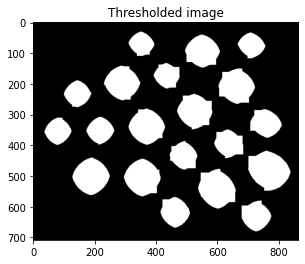

In [10]:

img_erode = morphological_operate(img_t,SE,'erode')
img_erode = morphological_operate(img_erode,SE,'erode')
plt.imshow(img_erode,cmap='gray')
plt.title("Thresholded image")
plt.show()

non-zero pixel found at  31 , 348
non-zero pixel found at  34 , 704
non-zero pixel found at  40 , 548
non-zero pixel found at  133 , 430
non-zero pixel found at  142 , 284
non-zero pixel found at  151 , 663
non-zero pixel found at  189 , 142
non-zero pixel found at  233 , 521
non-zero pixel found at  281 , 367
non-zero pixel found at  283 , 748
non-zero pixel found at  307 , 217
non-zero pixel found at  310 , 80
non-zero pixel found at  349 , 628
non-zero pixel found at  386 , 493
non-zero pixel found at  418 , 755
non-zero pixel found at  440 , 190
non-zero pixel found at  444 , 352
non-zero pixel found at  477 , 601
non-zero pixel found at  568 , 457
non-zero pixel found at  580 , 732
Total Time taken =  5164.24009346962


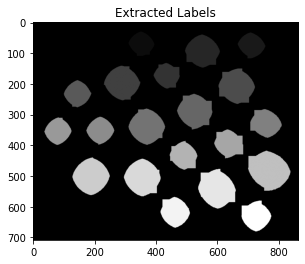

Number of components =  20


In [14]:
SE = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
out,N = find_labels(img_erode.copy(),SE)
plt.imshow(out,cmap='gray')
plt.title('Extracted Labels')
plt.show()
print('Number of components = ',N)

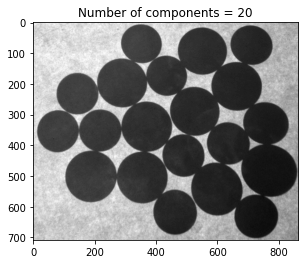

In [15]:
plt.imshow(img,cmap='gray')
plt.title("Number of components = "+str(N))
plt.show()